<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-и-предобработка-данных" data-toc-modified-id="Описание-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-первичный-анализ-данных" data-toc-modified-id="Загрузка-и-первичный-анализ-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка и первичный анализ данных</a></span></li><li><span><a href="#Лемматизация-текстов" data-toc-modified-id="Лемматизация-текстов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Лемматизация текстов</a></span></li><li><span><a href="#Отчистка-текста" data-toc-modified-id="Отчистка-текста-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Отчистка текста</a></span></li><li><span><a href="#Деление-данных-на-трейн-и-тест" data-toc-modified-id="Деление-данных-на-трейн-и-тест-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Деление данных на трейн и тест</a></span></li></ul></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost-классификация" data-toc-modified-id="CatBoost-классификация-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost классификация</a></span></li></ul></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговые выводы</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import wordnet

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elizaveta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Elizaveta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elizaveta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.pipeline import Pipeline

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Проект для «Викишоп»

## Описание проекта

**Заказчик** - интернет-магазин «Викишоп», который планирует запустить новый сервис. Благодаря данному сервису пользователи смогут редактировать и дополнять описания товаров подобно тому, как это делается в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию - модель, которая будет классифицировать комментарии на позитивные и негативные. При этом нужно достичь значение метрики качества F1 не меньше 0.75.

**Исходные данные** - набор данных с разметкой о токсичности правок.

## Описание и предобработка данных

### Загрузка и первичный анализ данных

Начнем работу с загрузки данных.

In [4]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', on_bad_lines='skip')
except:
    data = pd.read_csv('toxic_comments.csv', on_bad_lines='skip')

Также перед началом работы выведем основную информацию об исходных данных.

In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Исходный набор данных состоит из почти 160 тыс. наблюдений. Информативных столбца два: сам текст описания или правки, а также пометка о том, был ли отнесен данных текст к категории "токсичный" или нет. Пропусков в данных не обнаружено, тип переменных соответствует их смыслу.

Дополнительно рассмотрим переменную 'toxic' на распределение классов.

<AxesSubplot:xlabel='toxic', ylabel='count'>

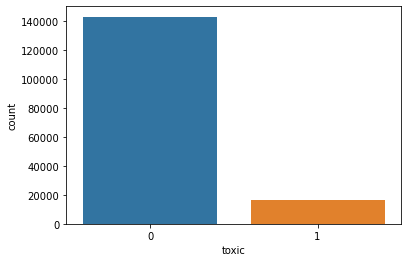

In [6]:
sns.countplot(x = 'toxic', data = data)

Как можно заметить превалирует нулевой класс, т.е. те комментарии, которые не были отмечены как токсичные. Это будет необходимо учесть при разбиении на подвыборки и в процессе обучения моделей. 

### Лемматизация текстов

Начнем предобработку текстов. Для начала проведем лемматизацию. Поскольку используемый нами лемматайзер наиболее эффективно обрабатывает слова, зная их часть речи, дополнительно создадим функцию, которая присвоит каждому слову в тексте соответствующую ему часть речи.

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

Также создадим функцию, которая будет проводить процедуру лемматизации для всех наблюдений. На вход она получает строку, после чего делит текст пословно и определяет часть речи каждого слова. После этого, зная слово и его часть речи, лемматайзер будет приводить слово к исходной форме. По итогу функция возвращает строку, в которой все слова приведены к исходной форме.

In [9]:
def lemms_creating(row):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(row['text'])) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

Применим получившиеся функции к данным и выведем полученный результат.

In [10]:
data['text']= data.apply(lemms_creating, axis=1)

In [11]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation Why the edits make under my userna...,0
1,1,D'aww ! He match this background colour I 'm s...,0
2,2,"Hey man , I 'm really not try to edit war . It...",0
3,3,`` More I ca n't make any real suggestion on i...,0
4,4,"You , sir , be my hero . Any chance you rememb...",0


Как можно заметить, преобразование в большинстве своем прошло успешно - не были обработан только слова с ошибками  и опечатки.

### Отчистка текста

Теперь проведем чистку текста от ненужных символов, т.е. оставим только буквы и пробелы.

In [12]:
def clear_text(row):
    text_new = re.sub(r'[^a-zA-Z ]', ' ', row['text'])
    text_new = text_new.split()
    text_new = " ".join(text_new)
    return text_new

In [13]:
data['text'] = data.apply(clear_text, axis=1)

In [14]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation Why the edits make under my userna...,0
1,1,D aww He match this background colour I m seem...,0
2,2,Hey man I m really not try to edit war It s ju...,0
3,3,More I ca n t make any real suggestion on impr...,0
4,4,You sir be my hero Any chance you remember wha...,0


Чистка текста также прошла успешно - ненужные и неинформативные символы были удалены.

### Деление данных на трейн и тест

На текущий момент предобработка закончена. Теперь поделим наши обработанные данные на тренировочные и тестовые.

In [15]:
X = data[['text']].copy()
y = data[['toxic']].copy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    shuffle = True,
                                                    random_state = 9)

In [17]:
X_train.head()

,text
129813,From the lead onwards the page refers to chip ...
116545,The English language literature do talk a lot ...
90600,Being intimidate at the poll place get my clea...
84698,PICTURE YOUR MOTHER WITH HER WRINKLED UP ASS I...
101620,I ll be go back myself to look at the date est...


Мы изучили исходные данные, обработали текст: перевели все слова к исходным формам, а также почистили их от ненужных символов. Теперь мы можем приступить к этапу моделирования. 

## Построение моделей

В данном проекте мы рассмотрим три группы моделей: логистическую регрессию, случайный лес и CatBoost классификатор. Для каждой из моделей мы попытаемся подобрать наилучшие параметры основываясь на значении метрики качества F1-score.

Для оптимизации работы и более справедливой оценки на кросс-валидации дополнительно создадим пайплайн, который сначала будет проводить векторизацию текстов посредством функции TF-IDF, а потом обучать заданную модель. 

### Логистическая регрессия

Начнем с логистической регрессии. После обучения выведем среднее качество лучшей модели по cv.

In [18]:
stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [19]:
logit = LogisticRegression(random_state=9, class_weight='balanced')
params_log = {'logit__C': np.logspace(-5, 8, 15),'logit__penalty':['l2']}
pipeline =  Pipeline([("vectorization", count_tf_idf), ("logit", logit)])
cv_log = RandomizedSearchCV(pipeline, param_distributions=params_log,
                      cv=3, scoring='f1', n_jobs=-1)
cv_log.fit(X_train['text'], y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vectorization',
                                              TfidfVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'ain',
                                                                          'all',
                                                                          'am',
                                                                          'an',
                                                                          'and',
             

In [20]:
cv_log.best_score_

0.7537072044594503

Модель логистической регрессии показала неплохое качество на тренировочных данных, а также сумела пересечь порог по необходимому качеству - хоть и по нижней границе. 

### Случайный лес

Теперь повторим процедуру подбора параметров для случайного леса. 

In [21]:
forest = RandomForestClassifier(random_state=9, n_jobs=-1, class_weight='balanced')
params_forest = {'random_forest__max_depth': range (1, 7, 1), 'random_forest__max_features': ['auto', 'sqrt', 'log2'], 
                 'random_forest__n_estimators': range(90, 120, 10)}
pipeline =  Pipeline([('vectorization', count_tf_idf), ("random_forest", forest)])
cv_forest = RandomizedSearchCV(pipeline, param_distributions=params_forest,
                      cv=3, scoring='f1', n_jobs=-1)
cv_forest.fit(X_train['text'], y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vectorization',
                                              TfidfVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'ain',
                                                                          'all',
                                                                          'am',
                                                                          'an',
                                                                          'and',
             

In [22]:
cv_forest.best_score_

0.34720463587716993

Модель случайного леса имеет куда более низкий уровень качества, а также не пересекает заявленный заказчиком порог - данная модель исключается из дальнейшего рассмотрения.

### CatBoost классификация

Наконец, построим модель CatBoost классификации.

In [23]:
cat = CatBoostClassifier(random_state=9, verbose=False)
params_cat = {'cat__n_estimators': range(90, 120, 10),
               'cat__depth': range (1, 7, 1), 'cat__grow_policy': ['Depthwise']}
pipeline =  Pipeline([('vectorization', count_tf_idf), ("cat", cat)])
cat_cv = RandomizedSearchCV(pipeline, params_cat, cv=3, scoring='f1', n_jobs=-1)
cat_cv.fit(X_train['text'], y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vectorization',
                                              TfidfVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'ain',
                                                                          'all',
                                                                          'am',
                                                                          'an',
                                                                          'and',
             

In [24]:
cat_cv.best_score_

0.7371877958028165

Модель классификации CatBoost показала неплохой результат на тренировочных данных, однако она не смогла пересечь порог качества, так что она также исключается из дальнейшего рассмотрения.

По итогу мы остановились на модели логистической регрессии - она не только была единственной моделью, которой удалось пересечь минимальный порог качества, но также имела наибольшее значение f1 статистики на тренировочных данных. Оценим, как будет работать наша итоговая модель на тренировочных данных.

In [26]:
f1_score(y_test, cv_log.predict(X_test['text']))

0.7508926119198024

Наша итоговая модель отлично показала себя и на тренировочных данных - значение f1 статистики почти не изменилось, что свидетельствует о минимальном переобучении нашей модели. 

## Итоговые выводы

Перед нами стояла задача создать модель, которая по предлагаемому ей тексту будет определять, является ли этот текст токсичным или нет. 

На первом этапе работы мы провели первичную обработку исходных текстов:
* перевели тексты в нужную кодировку
* лемматизировали исходные тексты
* удалили ненужные и неинформативные слова
* почистили  тексты от стоп-слов
* провели оценку значимости каждого слова в тексте

После этапа предобработки мы перешли к этапу моделирования. Нами были рассмотрены три модели: логистическая регрессия, случайный лес и CatBoost классификатор. В качестве итоговой была выбрана модель логистической регрессии - именно она имела наилучшее качество на тренировочных данных, а также соответствовала запросу заказчика в f1-score не ниже 0,75. 

На тестовых данных итоговая модель показала себя отлично - величина f1 статистики почти не отличается от аналогичного показателя на тренировочных данных, что свидетельствует о минимальном переобучении итоговой модели. 